In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", interp_length=None, transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.interp_length = interp_length
        self.filter = filter

    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        # Process ADC channels.
        if self.interp_length is not None:
            audio_arr = self._interpolate_channel(audio_arr, self.interp_length)
            adc1_arr = self._interpolate_channel(adc1_arr, self.interp_length)
            adc2_arr = self._interpolate_channel(adc2_arr, self.interp_length)
        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            torch.from_numpy(audio_arr.copy()).float(),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def _interpolate_channel(self, arr, target_length):
        """
        Remove np.inf values from the array and linearly interpolate
        to the target_length.
        """
        # Remove padded inf values.
        valid = arr[~np.isinf(arr)]
        if len(valid) == 0:
            # If there is no valid data, return an array of zeros.
            return np.zeros(target_length, dtype=arr.dtype)
        # Generate new indices for interpolation.
        old_indices = np.arange(len(valid))
        new_indices = np.linspace(0, len(valid) - 1, target_length)
        return np.interp(new_indices, old_indices, valid)[:target_length]

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        return filtered_data

class normalizer():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        id, audio, adc1, adc2 = sample
        audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[1]) / self.std[1]
        adc2 = (adc2 - self.mean[1]) / self.std[1]
        return id, audio, adc1, adc2

input_length = 600
# Path to the descriptor JSON file.
descriptor_path = 'samdescriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
dataset = MemmapDataset(descriptor_path, padding_handling="remove", interp_length=input_length, filter=True)
# dataset = MemmapDataset(descriptor_path, padding_handling="remove", filter=True)
transform = normalizer(mean=[dataset.get("audio_mean"), dataset.get("adc_mean")], std=[dataset.get("audio_std"), dataset.get("adc_std")])
dataset.transform = transform
output_length = dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = dataset[1]
print(f"\nWith ADC interpolation to length {input_length}:")
print("ADC1 shape:", sample[2].shape)
print("ADC2 shape:", sample[3].shape)

# Demonstrate accessing a descriptor field.
print("Audio Sampling Rate:", dataset.get("audio_sampling_rate"))
print("ADC Highcut:", dataset.get("adc_highcut"))


Number of classes: 38

With ADC interpolation to length 600:
ADC1 shape: torch.Size([600])
ADC2 shape: torch.Size([600])
Audio Sampling Rate: 48000
ADC Highcut: 3700


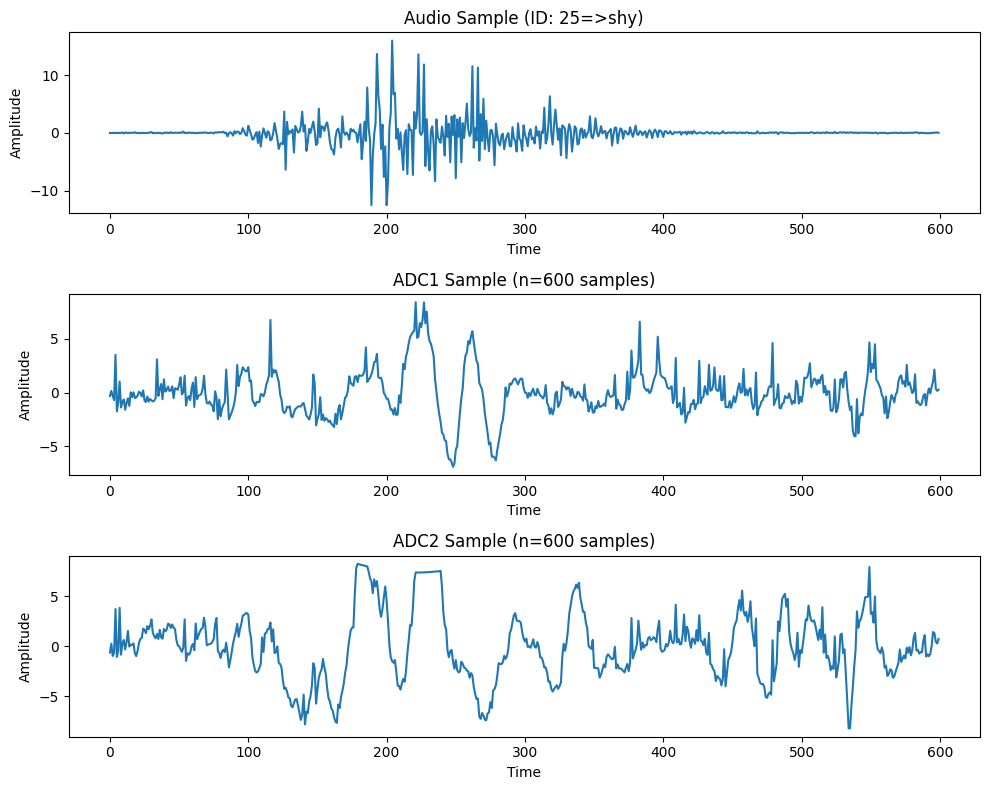

In [2]:
import matplotlib.pyplot as plt


rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

sample_id, audio, adc1, adc2 = sample  # unpack the tuple

# Convert tensors to numpy arrays for plotting
audio_np = audio.numpy()
adc1_np = adc1.numpy()
adc2_np = adc2.numpy()

# Create a figure with three subplots for audio, ADC1, and ADC2.
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

axs[0].plot(audio_np)
axs[0].set_title(f"Audio Sample (ID: {sample_id}=>{dataset.id_to_dataset(sample_id)})")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].plot(adc1_np)
axs[1].set_title(f"ADC1 Sample (n={len(adc1_np)} samples)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

axs[2].plot(adc2_np)
axs[2].set_title(f"ADC2 Sample (n={len(adc2_np)} samples)")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [3]:
# from torchprofile import profile_macs

import torch.nn as nn
import torch.nn.functional as F

# the data shape is (batch_size, 2, input_length)
# where 2 is the number of ADC channels and input_length is the length of each ADC channel.
# the output shape is (batch_size, output_length) where output_length is the number of classes.

# def computeModelStats(model, input_shape):
#     dummy_input = torch.randn(input_shape)
#     macs = profile_macs(model, dummy_input)
#     params = sum(p.numel() for p in model.parameters())
#     model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
#     print(f"MACs: {macs}")
#     print(f"Parameters: {params}")
#     print(f"Model Size: {model_size:.2f} MB")

def computeModelSize(model):
    params = sum(p.numel() for p in model.parameters())
    model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
    return model_size


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class AudioResNet(nn.Module):
    def __init__(self, input_length, input_dim,output_length):
        super(AudioResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 128, 2)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)
        self.layer4 = self._make_layer(512, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ResNet(nn.Module):
    def __init__(self, input_length, input_dim,output_length):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer( 64, 128, 4)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)
        self.layer4 = self._make_layer(512, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



class SmallResNet(nn.Module):
    def __init__(self, input_length, input_dim, output_length):
        super(SmallResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ELU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(32, 64, 4)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 4, stride=2)
        self.layer4 = self._make_layer(256, 512, 4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class InceptionBlock(nn.Module):
    """
    An Inception-style block for 1D signals.
    Each block includes:
      1) Optional bottleneck conv (1x1) to reduce input channels if needed
      2) Three parallel conv branches with different kernel sizes
      3) A parallel max-pool branch
      4) Concatenation of all branches
      5) A 1x1 'linear' conv to reduce channels back to 'out_channels'
      6) Optional skip connection if use_residual=True
    """
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 kernel_sizes: list = [9, 19, 39],
                 bottleneck_channels: int = 32,
                 use_residual: bool = True):
        """
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels (post concatenation reduction)
            kernel_sizes: Sizes for the parallel convolutions
            bottleneck_channels: Bottleneck channels for the optional 1x1 conv
            use_residual: Whether to add a residual (skip) connection
        """
        super(InceptionBlock, self).__init__()
        self.use_residual = use_residual
        
        # 1) Bottleneck if input channels are larger than the bottleneck size
        if in_channels > bottleneck_channels:
            self.bottleneck = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
            self.bottleneck_bn = nn.BatchNorm1d(bottleneck_channels)
            conv_in = bottleneck_channels
        else:
            self.bottleneck = None
            conv_in = in_channels
        
        # 2) Three parallel conv branches with different kernel sizes
        self.branch1 = nn.Sequential(
            nn.Conv1d(conv_in, out_channels, kernel_size=kernel_sizes[0], 
                      padding=kernel_sizes[0] // 2, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ELU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.Conv1d(conv_in, out_channels, kernel_size=kernel_sizes[1], 
                      padding=kernel_sizes[1] // 2, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ELU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv1d(conv_in, out_channels, kernel_size=kernel_sizes[2], 
                      padding=kernel_sizes[2] // 2, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ELU(inplace=True)
        )

        # 3) Pooling branch
        self.branch4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ELU(inplace=True)
        )

        # 4) 1x1 'linear' conv to reduce from 4*out_channels -> out_channels
        self.conv_linear = nn.Conv1d(4 * out_channels, out_channels, kernel_size=1, bias=False)
        self.conv_linear_bn = nn.BatchNorm1d(out_channels)
        
        # If using a residual connection but in_channels != out_channels, we align dims
        self.skip_conv = None
        if use_residual and in_channels != out_channels:
            self.skip_conv = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        self.final_activation = nn.ELU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Bottleneck if configured
        if self.bottleneck is not None:
            x_bottleneck = self.bottleneck_bn(self.bottleneck(x))
        else:
            x_bottleneck = x

        # Parallel branches
        out1 = self.branch1(x_bottleneck)
        out2 = self.branch2(x_bottleneck)
        out3 = self.branch3(x_bottleneck)
        out4 = self.branch4(x)

        # Concatenate
        merged = torch.cat([out1, out2, out3, out4], dim=1)   # (B, 4*out_channels, L)

        # Linear conv to get back to out_channels
        merged = self.conv_linear_bn(self.conv_linear(merged))  # (B, out_channels, L)

        # Residual/skip connection
        if self.use_residual:
            skip = x
            if self.skip_conv is not None:
                skip = self.skip_conv(x)
            merged = self.final_activation(merged + skip)
        else:
            merged = self.final_activation(merged)

        return merged


class InceptionTime(nn.Module):
    """
    An InceptionTime model that stacks several InceptionBlocks in sequence
    and then applies global average pooling + a final linear classifier.
    """
    def __init__(self, 
                 input_length: int,
                 input_dim: int,
                 output_length: int,
                 num_filters: int = 32,
                 bottleneck_channels: int = 32,
                 num_inception_blocks: int = 3):
        """
        Args:
            input_length: Unused directly here, but kept for parity with other models.
            input_dim: Number of input channels (e.g., 2 if you have 2 ADC channels).
            output_length: Number of output classes.
            num_filters: Base number of filters for each inception branch
            bottleneck_channels: Bottleneck size for optional 1x1 conv
            num_inception_blocks: How many Inception blocks to stack
        """
        super(InceptionTime, self).__init__()
        
        blocks = []
        current_in_channels = input_dim
        for _ in range(num_inception_blocks):
            block = InceptionBlock(
                in_channels=current_in_channels,
                out_channels=num_filters,
                kernel_sizes=[9, 19, 39],
                bottleneck_channels=bottleneck_channels,
                use_residual=True
            )
            blocks.append(block)
            current_in_channels = num_filters
        
        self.inception_blocks = nn.Sequential(*blocks)
        
        # Adaptive average pool to (B, C, 1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Final fully-connected classification layer
        self.fc = nn.Linear(num_filters, output_length)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pass input through stacked Inception blocks
        x = self.inception_blocks(x)  # (B, num_filters, L)
        
        # Global average pool
        x = self.global_pool(x)       # (B, num_filters, 1)
        x = x.squeeze(-1)            # (B, num_filters)
        
        # Fully-connected classification
        x = self.fc(x)               # (B, output_length)
        return x

# Test the model with dummy data
dummy = torch.randn(4, 2, input_length)
# model = ResNet(input_length, 2, output_length)
model = InceptionTime(input_length, 2, output_length, num_filters=128, bottleneck_channels=64, num_inception_blocks=5)  # For InceptionTime
amodel = AudioResNet(input_length, 1, output_length)  # For AudioResNet
amodel.load_state_dict(torch.load("best_audiomodel.pth"), strict=False)  # Load weights from "best_audiomodel.pth"
# Smodel = SmallResNet(input_length, 2, output_length)
output = model(dummy)
# Soutput = Smodel(dummy)
print("Output shape is:", output.shape)
print(model)
# print("Small Output shape is:", Soutput.shape)
# print(Smodel)

# Compute model stats
# computeModelStats(model, (1, 2, input_length))
print(f"Model Size: {computeModelSize(model):.2f} MB")
# print(f"Small Model Size: {computeModelSize(Smodel):.2f} MB")

Output shape is: torch.Size([4, 38])
InceptionTime(
  (inception_blocks): Sequential(
    (0): InceptionBlock(
      (branch1): Sequential(
        (0): Conv1d(2, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0, inplace=True)
      )
      (branch2): Sequential(
        (0): Conv1d(2, 128, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0, inplace=True)
      )
      (branch3): Sequential(
        (0): Conv1d(2, 128, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0, inplace=True)
      )
      (branch4): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=Fa

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epoch(
    model,
    dataloader,
    epochs,
    learning_rate,
    optimizer=None,
    loss_function=None,
    scheduler=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
    amodel=None  # Pass the AudioResNet model for the second output comparison
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()
    amodel.to(device)  # Ensure the teacher model is also on the same device
    amodel.eval()  # Set the teacher model to evaluation mode

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Training Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
            audio = audio.to(device)
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            adc+= torch.randn_like(adc) * 0.04
            outputs = model(adc)

            with torch.no_grad():
                teacher_outputs = amodel(audio.unsqueeze(1))  # Pass audio through AudioResNet (teacher model)
            
            loss1 = loss_function(outputs, ids)  # Standard classification loss
            loss2 = nn.KLDivLoss(reduction="batchmean")(
                torch.log_softmax(outputs / 2.0, dim=1),  # Student logits (scaled)
                torch.softmax(teacher_outputs / 2.0, dim=1)  # Teacher logits (scaled)
            )  # Knowledge distillation loss
            # Combine the two losses
            loss = loss1 + 0.9 * loss2
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == ids).sum().item()
            total += ids.size(0)
            
            # if verbose > 0 and (batch_idx % log_interval == 0):
            #     msg = f"[TRAIN] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
            #     if verbose == 1:
            #         print(msg)
            #     if logger is not None and verbose != 0:
            #         logger.log({"split": "train", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TRAIN] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "train", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})


    return epoch_results


def test_epoch(
    model,
    dataloader,
    epochs=1,
    loss_function=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Testing Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
                ids = ids.to(device)
                adc1 = adc1.to(device)
                adc2 = adc2.to(device)
                audio = audio.to(device)  # Ensure audio is on the same device
                
                adc = torch.stack((adc1, adc2), dim=1)
                outputs = model(adc)
                loss = loss_function(outputs, ids)
                
                total_loss += loss.item()
                num_batches += 1
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == ids).sum().item()
                total += ids.size(0)
                
                # if verbose > 0 and (batch_idx % log_interval == 0):
                #     msg = f"[TEST] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                #     if verbose == 1:
                #         print(msg)
                #     if logger is not None and verbose != 0:
                #         logger.log({"split": "test", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TEST] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "test", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})

    return epoch_results


In [5]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.7
val_ratio = 0.3

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, audio, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, audio, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([ 7, 24, 27, 18, 27,  8,  4,  9, 21,  9, 34, 25, 13,  1, 13, 32,  1, 23,
        33, 12, 27, 16, 30, 34,  7, 15, 31, 29, 36, 33, 27, 34])
Audio shape: torch.Size([32, 600])
ADC1 shape: torch.Size([32, 600])
ADC2 shape: torch.Size([32, 600])
Batch 2:
IDs: tensor([ 4, 10, 18, 12, 12,  6, 24,  9,  6, 36,  5, 36,  4, 30, 16, 12, 12, 12,
        36, 32, 24, 12, 14, 33, 19,  7,  6, 32, 20, 20,  8, 21])
Audio shape: torch.Size([32, 600])
ADC1 shape: torch.Size([32, 600])
ADC2 shape: torch.Size([32, 600])
Batch 1:
IDs: tensor([20, 15, 20, 35,  1, 34, 12,  8,  1, 31, 34, 32, 15, 22,  4,  4, 28,  8,
        31, 33, 23, 19, 16, 33, 32, 37, 20, 27, 24, 36,  2, 28])
Audio shape: torch.Size([32, 600])
ADC1 shape: torch.Size([32, 600])
ADC2 shape: torch.Size([32, 600])
Batch 2:
IDs: tensor([ 6, 35, 23, 29, 31, 23, 32,  4, 22,  7, 10, 35, 17, 16, 18, 31, 15, 36,
        37, 25, 20, 10, 37, 14, 24, 33, 29, 12, 10,  5, 18, 18])
Audio shape: torch.Size([32, 600])
ADC1 shape: torch.Si

In [6]:
# !wandb login

In [7]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [8]:
TOTAL_EPOCHS = 240
PER_EPOCH = 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2)
# criterion = torch.nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", global_device)
verbosity = 1

Using device: cuda:0


In [9]:
# the actual trainign loop
train_stats = []
test_stats = []
for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res =train_epoch(model, train_loader, epochs=2, learning_rate=0.001, device=global_device, verbose=1, scheduler=scheduler, optimizer=optimizer, loss_function=criterion, amodel=amodel)
    train_stats.extend(res)
    res = test_epoch(model, val_loader, epochs=1, device=global_device, verbose=1, loss_function=criterion)
    test_stats.extend(res)



TOTAL Epochs:   0%|          | 0/240 [00:00<?, ?it/s]

[TRAIN] End of Epoch 0, Avg Loss: 3.3426, Accuracy: 19.71%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.9461, Accuracy: 36.16%


TOTAL Epochs:   0%|          | 1/240 [00:04<16:54,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 2.6782, Accuracy: 40.18%


[TRAIN] End of Epoch 0, Avg Loss: 2.7086, Accuracy: 52.17%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.5526, Accuracy: 59.38%


TOTAL Epochs:   1%|          | 2/240 [00:08<15:45,  3.97s/it]

[TEST] End of Epoch 0, Avg Loss: 2.3703, Accuracy: 56.70%


[TRAIN] End of Epoch 0, Avg Loss: 2.4171, Accuracy: 65.50%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.2902, Accuracy: 73.41%


TOTAL Epochs:   1%|▏         | 3/240 [00:11<15:22,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 2.1014, Accuracy: 74.26%


[TRAIN] End of Epoch 0, Avg Loss: 2.1914, Accuracy: 77.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.1196, Accuracy: 80.93%


TOTAL Epochs:   2%|▏         | 4/240 [00:15<15:09,  3.85s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0150, Accuracy: 79.46%


[TRAIN] End of Epoch 0, Avg Loss: 2.0396, Accuracy: 84.89%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.0034, Accuracy: 86.29%


TOTAL Epochs:   2%|▏         | 5/240 [00:18<13:14,  3.38s/it]

[TEST] End of Epoch 0, Avg Loss: 1.9407, Accuracy: 80.80%


[TRAIN] End of Epoch 0, Avg Loss: 2.2338, Accuracy: 74.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.1667, Accuracy: 75.38%


TOTAL Epochs:   2%|▎         | 6/240 [00:21<13:42,  3.51s/it]

[TEST] End of Epoch 0, Avg Loss: 2.1415, Accuracy: 66.52%


[TRAIN] End of Epoch 0, Avg Loss: 2.1000, Accuracy: 80.10%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.0337, Accuracy: 81.44%


TOTAL Epochs:   3%|▎         | 7/240 [00:25<14:04,  3.62s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0853, Accuracy: 68.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.9871, Accuracy: 83.99%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.9484, Accuracy: 86.10%


TOTAL Epochs:   3%|▎         | 8/240 [00:29<14:14,  3.68s/it]

[TEST] End of Epoch 0, Avg Loss: 1.9146, Accuracy: 76.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.8947, Accuracy: 88.20%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8511, Accuracy: 89.99%


TOTAL Epochs:   4%|▍         | 9/240 [00:33<14:19,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8672, Accuracy: 78.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.8261, Accuracy: 91.01%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7915, Accuracy: 91.71%


TOTAL Epochs:   4%|▍         | 10/240 [00:37<14:22,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8221, Accuracy: 82.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.7467, Accuracy: 93.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7368, Accuracy: 94.01%


TOTAL Epochs:   5%|▍         | 11/240 [00:41<14:25,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8049, Accuracy: 79.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.6965, Accuracy: 94.07%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6779, Accuracy: 95.85%


TOTAL Epochs:   5%|▌         | 12/240 [00:44<14:21,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8297, Accuracy: 81.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.6469, Accuracy: 96.49%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6084, Accuracy: 97.51%


TOTAL Epochs:   5%|▌         | 13/240 [00:47<12:55,  3.42s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7309, Accuracy: 85.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.5773, Accuracy: 98.02%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5635, Accuracy: 98.79%


TOTAL Epochs:   6%|▌         | 14/240 [00:51<13:15,  3.52s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7019, Accuracy: 84.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.5420, Accuracy: 99.30%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5118, Accuracy: 99.55%


TOTAL Epochs:   6%|▋         | 15/240 [00:54<13:29,  3.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7015, Accuracy: 87.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.4900, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4834, Accuracy: 99.55%


TOTAL Epochs:   7%|▋         | 16/240 [00:58<13:41,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6637, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.4648, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4449, Accuracy: 99.81%


TOTAL Epochs:   7%|▋         | 17/240 [01:02<13:48,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6530, Accuracy: 89.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.4359, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4329, Accuracy: 99.87%


TOTAL Epochs:   8%|▊         | 18/240 [01:06<13:52,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6405, Accuracy: 89.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.4267, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4127, Accuracy: 100.00%


TOTAL Epochs:   8%|▊         | 19/240 [01:10<13:53,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6400, Accuracy: 88.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.4078, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4101, Accuracy: 100.00%


TOTAL Epochs:   8%|▊         | 20/240 [01:14<13:53,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6261, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.7212, Accuracy: 93.05%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7075, Accuracy: 94.20%


TOTAL Epochs:   9%|▉         | 21/240 [01:17<13:52,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.9280, Accuracy: 75.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.6578, Accuracy: 95.85%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6298, Accuracy: 95.85%


TOTAL Epochs:   9%|▉         | 22/240 [01:20<12:30,  3.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8577, Accuracy: 77.68%


[TRAIN] End of Epoch 0, Avg Loss: 1.6012, Accuracy: 97.19%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5561, Accuracy: 98.79%


TOTAL Epochs:  10%|▉         | 23/240 [01:24<12:51,  3.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8037, Accuracy: 82.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.5617, Accuracy: 98.21%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5337, Accuracy: 98.92%


TOTAL Epochs:  10%|█         | 24/240 [01:28<13:08,  3.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7240, Accuracy: 83.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.5313, Accuracy: 98.28%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5049, Accuracy: 99.11%


TOTAL Epochs:  10%|█         | 25/240 [01:32<13:21,  3.73s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7055, Accuracy: 86.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.4942, Accuracy: 99.43%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4831, Accuracy: 99.55%


TOTAL Epochs:  11%|█         | 26/240 [01:36<13:36,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7540, Accuracy: 84.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.4746, Accuracy: 99.74%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4650, Accuracy: 99.81%


TOTAL Epochs:  11%|█▏        | 27/240 [01:40<13:40,  3.85s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7359, Accuracy: 84.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.4500, Accuracy: 99.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4509, Accuracy: 99.43%


TOTAL Epochs:  12%|█▏        | 28/240 [01:44<13:52,  3.93s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6884, Accuracy: 86.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.4528, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4389, Accuracy: 99.87%


TOTAL Epochs:  12%|█▏        | 29/240 [01:48<13:52,  3.94s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7116, Accuracy: 86.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.4262, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4352, Accuracy: 99.81%


TOTAL Epochs:  12%|█▎        | 30/240 [01:51<12:38,  3.61s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6654, Accuracy: 87.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.4271, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4042, Accuracy: 100.00%


TOTAL Epochs:  13%|█▎        | 31/240 [01:54<12:48,  3.68s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6818, Accuracy: 87.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.3865, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4095, Accuracy: 99.87%


TOTAL Epochs:  13%|█▎        | 32/240 [01:58<12:55,  3.73s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7352, Accuracy: 83.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3890, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3753, Accuracy: 99.94%


TOTAL Epochs:  14%|█▍        | 33/240 [02:02<12:58,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6405, Accuracy: 87.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.3864, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3846, Accuracy: 99.94%


TOTAL Epochs:  14%|█▍        | 34/240 [02:06<12:59,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6549, Accuracy: 88.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.3888, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3733, Accuracy: 100.00%


TOTAL Epochs:  15%|█▍        | 35/240 [02:10<12:59,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6493, Accuracy: 87.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.3584, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3608, Accuracy: 100.00%


TOTAL Epochs:  15%|█▌        | 36/240 [02:14<12:59,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7038, Accuracy: 86.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.3678, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3667, Accuracy: 99.94%


TOTAL Epochs:  15%|█▌        | 37/240 [02:17<13:00,  3.85s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6553, Accuracy: 88.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.3606, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3594, Accuracy: 100.00%


TOTAL Epochs:  16%|█▌        | 38/240 [02:20<11:42,  3.48s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6647, Accuracy: 87.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.3439, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3439, Accuracy: 100.00%


TOTAL Epochs:  16%|█▋        | 39/240 [02:24<12:02,  3.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6364, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.3293, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3363, Accuracy: 100.00%


TOTAL Epochs:  17%|█▋        | 40/240 [02:28<12:12,  3.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6308, Accuracy: 89.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.3356, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3308, Accuracy: 100.00%


TOTAL Epochs:  17%|█▋        | 41/240 [02:32<12:19,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6256, Accuracy: 88.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.3262, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3335, Accuracy: 100.00%


TOTAL Epochs:  18%|█▊        | 42/240 [02:35<12:24,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6355, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3280, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3222, Accuracy: 100.00%


TOTAL Epochs:  18%|█▊        | 43/240 [02:39<12:28,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6415, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.3158, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3110, Accuracy: 100.00%


TOTAL Epochs:  18%|█▊        | 44/240 [02:43<12:26,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6415, Accuracy: 88.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.3187, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3091, Accuracy: 100.00%


TOTAL Epochs:  19%|█▉        | 45/240 [02:47<12:27,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6412, Accuracy: 89.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.3102, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3142, Accuracy: 100.00%


TOTAL Epochs:  19%|█▉        | 46/240 [02:51<12:27,  3.86s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6191, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3110, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3151, Accuracy: 100.00%


TOTAL Epochs:  20%|█▉        | 47/240 [02:54<11:10,  3.47s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6130, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.3037, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3010, Accuracy: 100.00%


TOTAL Epochs:  20%|██        | 48/240 [02:57<11:27,  3.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6225, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2994, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2969, Accuracy: 100.00%


TOTAL Epochs:  20%|██        | 49/240 [03:01<11:40,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6220, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2948, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2944, Accuracy: 100.00%


TOTAL Epochs:  21%|██        | 50/240 [03:05<11:46,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6197, Accuracy: 90.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2932, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2913, Accuracy: 100.00%


TOTAL Epochs:  21%|██▏       | 51/240 [03:09<11:49,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6320, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2911, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2938, Accuracy: 100.00%


TOTAL Epochs:  22%|██▏       | 52/240 [03:13<11:49,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6166, Accuracy: 91.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.2909, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2866, Accuracy: 100.00%


TOTAL Epochs:  22%|██▏       | 53/240 [03:17<11:49,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6188, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2836, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2846, Accuracy: 100.00%


TOTAL Epochs:  22%|██▎       | 54/240 [03:20<11:47,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6307, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2844, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2824, Accuracy: 100.00%


TOTAL Epochs:  23%|██▎       | 55/240 [03:23<10:35,  3.43s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6329, Accuracy: 91.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.2814, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2811, Accuracy: 100.00%


TOTAL Epochs:  23%|██▎       | 56/240 [03:27<10:53,  3.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6264, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2803, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2796, Accuracy: 100.00%


TOTAL Epochs:  24%|██▍       | 57/240 [03:31<11:05,  3.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6201, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2778, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2779, Accuracy: 100.00%


TOTAL Epochs:  24%|██▍       | 58/240 [03:35<11:13,  3.70s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6258, Accuracy: 91.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2787, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2772, Accuracy: 100.00%


TOTAL Epochs:  25%|██▍       | 59/240 [03:38<11:17,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6304, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2772, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2767, Accuracy: 100.00%


TOTAL Epochs:  25%|██▌       | 60/240 [03:42<11:18,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6254, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2748, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2738, Accuracy: 100.00%


TOTAL Epochs:  25%|██▌       | 61/240 [03:46<11:19,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6328, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2732, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2734, Accuracy: 100.00%


TOTAL Epochs:  26%|██▌       | 62/240 [03:50<11:18,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6343, Accuracy: 90.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2714, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2731, Accuracy: 100.00%


TOTAL Epochs:  26%|██▋       | 63/240 [03:53<10:10,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6287, Accuracy: 91.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2728, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2718, Accuracy: 100.00%


TOTAL Epochs:  27%|██▋       | 64/240 [03:56<10:27,  3.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6271, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2715, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2708, Accuracy: 100.00%


TOTAL Epochs:  27%|██▋       | 65/240 [04:00<10:39,  3.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6326, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.6106, Accuracy: 95.15%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6841, Accuracy: 94.52%


TOTAL Epochs:  28%|██▊       | 66/240 [04:04<10:45,  3.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8859, Accuracy: 75.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.5422, Accuracy: 98.09%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4610, Accuracy: 99.62%


TOTAL Epochs:  28%|██▊       | 67/240 [04:08<10:48,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7307, Accuracy: 82.89%


[TRAIN] End of Epoch 0, Avg Loss: 1.4279, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4277, Accuracy: 99.49%


TOTAL Epochs:  28%|██▊       | 68/240 [04:12<10:48,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7064, Accuracy: 86.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.3894, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3775, Accuracy: 100.00%


TOTAL Epochs:  29%|██▉       | 69/240 [04:16<10:47,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6971, Accuracy: 87.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.3677, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3556, Accuracy: 99.94%


TOTAL Epochs:  29%|██▉       | 70/240 [04:19<10:45,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6702, Accuracy: 87.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.3664, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3631, Accuracy: 99.94%


TOTAL Epochs:  30%|██▉       | 71/240 [04:23<10:44,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6323, Accuracy: 88.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.3631, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3632, Accuracy: 99.87%


TOTAL Epochs:  30%|███       | 72/240 [04:26<09:39,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6768, Accuracy: 88.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.3501, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3506, Accuracy: 100.00%


TOTAL Epochs:  30%|███       | 73/240 [04:30<09:57,  3.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6708, Accuracy: 87.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.3652, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3420, Accuracy: 100.00%


TOTAL Epochs:  31%|███       | 74/240 [04:34<10:08,  3.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6486, Accuracy: 87.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.3353, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3376, Accuracy: 100.00%


TOTAL Epochs:  31%|███▏      | 75/240 [04:37<10:14,  3.73s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6617, Accuracy: 88.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.3481, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3290, Accuracy: 100.00%


TOTAL Epochs:  32%|███▏      | 76/240 [04:41<10:17,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6399, Accuracy: 89.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.3308, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3338, Accuracy: 100.00%


TOTAL Epochs:  32%|███▏      | 77/240 [04:45<10:17,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6560, Accuracy: 87.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.3273, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3257, Accuracy: 100.00%


TOTAL Epochs:  32%|███▎      | 78/240 [04:49<10:18,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6546, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.3193, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3290, Accuracy: 100.00%


TOTAL Epochs:  33%|███▎      | 79/240 [04:53<10:16,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6408, Accuracy: 88.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.3361, Accuracy: 99.74%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3261, Accuracy: 100.00%


TOTAL Epochs:  33%|███▎      | 80/240 [04:55<09:13,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6560, Accuracy: 89.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.3182, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3236, Accuracy: 100.00%


TOTAL Epochs:  34%|███▍      | 81/240 [04:59<09:29,  3.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6584, Accuracy: 89.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.3369, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3359, Accuracy: 100.00%


TOTAL Epochs:  34%|███▍      | 82/240 [05:03<09:37,  3.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6711, Accuracy: 87.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.3433, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3325, Accuracy: 100.00%


TOTAL Epochs:  35%|███▍      | 83/240 [05:07<09:43,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6611, Accuracy: 87.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.3291, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3284, Accuracy: 100.00%


TOTAL Epochs:  35%|███▌      | 84/240 [05:11<09:49,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6528, Accuracy: 89.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.3281, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3220, Accuracy: 100.00%


TOTAL Epochs:  35%|███▌      | 85/240 [05:15<09:49,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6483, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3155, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3205, Accuracy: 100.00%


TOTAL Epochs:  36%|███▌      | 86/240 [05:19<09:47,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6453, Accuracy: 88.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.3246, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3199, Accuracy: 100.00%


TOTAL Epochs:  36%|███▋      | 87/240 [05:22<09:44,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6340, Accuracy: 89.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.3153, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3179, Accuracy: 100.00%


TOTAL Epochs:  37%|███▋      | 88/240 [05:25<08:46,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6663, Accuracy: 88.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.3124, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3196, Accuracy: 100.00%


TOTAL Epochs:  37%|███▋      | 89/240 [05:29<08:59,  3.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6264, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.3150, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3073, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 90/240 [05:33<09:10,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6500, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.3139, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3116, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 91/240 [05:37<09:15,  3.73s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6228, Accuracy: 91.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.3106, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3151, Accuracy: 100.00%


TOTAL Epochs:  38%|███▊      | 92/240 [05:41<09:15,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6257, Accuracy: 89.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.3142, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3046, Accuracy: 100.00%


TOTAL Epochs:  39%|███▉      | 93/240 [05:44<09:16,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6326, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.3053, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3048, Accuracy: 100.00%


TOTAL Epochs:  39%|███▉      | 94/240 [05:48<09:12,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6432, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.3028, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3152, Accuracy: 100.00%


TOTAL Epochs:  40%|███▉      | 95/240 [05:52<09:12,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6368, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.3186, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3172, Accuracy: 100.00%


TOTAL Epochs:  40%|████      | 96/240 [05:56<09:08,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7013, Accuracy: 85.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.3124, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3074, Accuracy: 100.00%


TOTAL Epochs:  40%|████      | 97/240 [05:58<08:13,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6340, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.3112, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3070, Accuracy: 100.00%


TOTAL Epochs:  41%|████      | 98/240 [06:02<08:26,  3.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6351, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.3025, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3091, Accuracy: 100.00%


TOTAL Epochs:  41%|████▏     | 99/240 [06:06<08:33,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6523, Accuracy: 89.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.3064, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3071, Accuracy: 100.00%


TOTAL Epochs:  42%|████▏     | 100/240 [06:10<08:37,  3.69s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6125, Accuracy: 91.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.3004, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2956, Accuracy: 100.00%


TOTAL Epochs:  42%|████▏     | 101/240 [06:14<08:39,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6431, Accuracy: 91.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.3026, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2989, Accuracy: 100.00%


TOTAL Epochs:  42%|████▎     | 102/240 [06:18<08:39,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6353, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2975, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3048, Accuracy: 99.87%


TOTAL Epochs:  43%|████▎     | 103/240 [06:21<08:37,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6452, Accuracy: 88.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.3027, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3085, Accuracy: 100.00%


TOTAL Epochs:  43%|████▎     | 104/240 [06:25<08:36,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6417, Accuracy: 91.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.3007, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2953, Accuracy: 100.00%


TOTAL Epochs:  44%|████▍     | 105/240 [06:28<07:44,  3.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6250, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2949, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2982, Accuracy: 100.00%


TOTAL Epochs:  44%|████▍     | 106/240 [06:32<07:55,  3.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6473, Accuracy: 89.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.3083, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3032, Accuracy: 100.00%


TOTAL Epochs:  45%|████▍     | 107/240 [06:35<08:03,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6500, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3029, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3025, Accuracy: 100.00%


TOTAL Epochs:  45%|████▌     | 108/240 [06:39<08:08,  3.70s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6531, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2977, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3007, Accuracy: 100.00%


TOTAL Epochs:  45%|████▌     | 109/240 [06:43<08:10,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6531, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2994, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2936, Accuracy: 100.00%


TOTAL Epochs:  46%|████▌     | 110/240 [06:47<08:11,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6588, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2975, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2848, Accuracy: 100.00%


TOTAL Epochs:  46%|████▋     | 111/240 [06:51<08:12,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6477, Accuracy: 91.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2854, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2927, Accuracy: 100.00%


TOTAL Epochs:  47%|████▋     | 112/240 [06:55<08:11,  3.84s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6476, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2908, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2971, Accuracy: 100.00%


TOTAL Epochs:  47%|████▋     | 113/240 [06:59<08:07,  3.84s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6659, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2983, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2994, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 114/240 [07:01<07:17,  3.47s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6529, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2983, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2992, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 115/240 [07:05<07:27,  3.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6459, Accuracy: 90.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2895, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2833, Accuracy: 100.00%


TOTAL Epochs:  48%|████▊     | 116/240 [07:09<07:35,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6442, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2866, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2853, Accuracy: 100.00%


TOTAL Epochs:  49%|████▉     | 117/240 [07:13<07:40,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6416, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2837, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2828, Accuracy: 100.00%


TOTAL Epochs:  49%|████▉     | 118/240 [07:17<07:40,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6329, Accuracy: 92.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2912, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2926, Accuracy: 100.00%


TOTAL Epochs:  50%|████▉     | 119/240 [07:21<07:39,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6512, Accuracy: 89.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2914, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2848, Accuracy: 100.00%


TOTAL Epochs:  50%|█████     | 120/240 [07:24<07:36,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6546, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2837, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2903, Accuracy: 99.94%


TOTAL Epochs:  50%|█████     | 121/240 [07:28<07:33,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6585, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2894, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2844, Accuracy: 100.00%


TOTAL Epochs:  51%|█████     | 122/240 [07:31<06:46,  3.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6176, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2810, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2795, Accuracy: 100.00%


TOTAL Epochs:  51%|█████▏    | 123/240 [07:35<06:56,  3.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6631, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2817, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2811, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▏    | 124/240 [07:39<07:02,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6356, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2818, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2796, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▏    | 125/240 [07:42<07:06,  3.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6722, Accuracy: 90.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2802, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2805, Accuracy: 100.00%


TOTAL Epochs:  52%|█████▎    | 126/240 [07:46<07:07,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6535, Accuracy: 89.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2771, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2796, Accuracy: 100.00%


TOTAL Epochs:  53%|█████▎    | 127/240 [07:50<07:07,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6240, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2761, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2743, Accuracy: 100.00%


TOTAL Epochs:  53%|█████▎    | 128/240 [07:54<07:05,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6405, Accuracy: 91.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2780, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2789, Accuracy: 100.00%


TOTAL Epochs:  54%|█████▍    | 129/240 [07:58<07:02,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6656, Accuracy: 90.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2752, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2770, Accuracy: 100.00%


TOTAL Epochs:  54%|█████▍    | 130/240 [08:00<06:17,  3.43s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6195, Accuracy: 91.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2871, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2853, Accuracy: 100.00%


TOTAL Epochs:  55%|█████▍    | 131/240 [08:04<06:27,  3.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6377, Accuracy: 91.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2798, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2797, Accuracy: 100.00%


TOTAL Epochs:  55%|█████▌    | 132/240 [08:08<06:33,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6601, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2807, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2762, Accuracy: 100.00%


TOTAL Epochs:  55%|█████▌    | 133/240 [08:12<06:36,  3.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6359, Accuracy: 91.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2757, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2751, Accuracy: 100.00%


TOTAL Epochs:  56%|█████▌    | 134/240 [08:16<06:37,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6556, Accuracy: 91.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2726, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2721, Accuracy: 100.00%


TOTAL Epochs:  56%|█████▋    | 135/240 [08:20<06:36,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6478, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2738, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2740, Accuracy: 100.00%


TOTAL Epochs:  57%|█████▋    | 136/240 [08:23<06:36,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6387, Accuracy: 91.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2759, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2729, Accuracy: 100.00%


TOTAL Epochs:  57%|█████▋    | 137/240 [08:27<06:32,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6384, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2707, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2693, Accuracy: 100.00%


TOTAL Epochs:  57%|█████▊    | 138/240 [08:31<06:30,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6578, Accuracy: 92.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2692, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2722, Accuracy: 100.00%


TOTAL Epochs:  58%|█████▊    | 139/240 [08:34<05:49,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6598, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2711, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2692, Accuracy: 100.00%


TOTAL Epochs:  58%|█████▊    | 140/240 [08:38<05:57,  3.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6454, Accuracy: 92.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2691, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2674, Accuracy: 100.00%


TOTAL Epochs:  59%|█████▉    | 141/240 [08:41<06:00,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6391, Accuracy: 91.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2674, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2682, Accuracy: 100.00%


TOTAL Epochs:  59%|█████▉    | 142/240 [08:45<06:03,  3.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6441, Accuracy: 93.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2692, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2720, Accuracy: 100.00%


TOTAL Epochs:  60%|█████▉    | 143/240 [08:49<06:05,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6555, Accuracy: 89.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2728, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2672, Accuracy: 100.00%


TOTAL Epochs:  60%|██████    | 144/240 [08:53<06:03,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6544, Accuracy: 92.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2676, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2691, Accuracy: 100.00%


TOTAL Epochs:  60%|██████    | 145/240 [08:57<06:02,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6334, Accuracy: 92.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2677, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2665, Accuracy: 100.00%


TOTAL Epochs:  61%|██████    | 146/240 [09:01<06:00,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6467, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2654, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2642, Accuracy: 100.00%


TOTAL Epochs:  61%|██████▏   | 147/240 [09:03<05:21,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6632, Accuracy: 92.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2641, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2615, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▏   | 148/240 [09:07<05:27,  3.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6650, Accuracy: 91.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2638, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2639, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▏   | 149/240 [09:11<05:30,  3.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6521, Accuracy: 91.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2659, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2650, Accuracy: 100.00%


TOTAL Epochs:  62%|██████▎   | 150/240 [09:15<05:32,  3.69s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6643, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2652, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2613, Accuracy: 100.00%


TOTAL Epochs:  63%|██████▎   | 151/240 [09:19<05:32,  3.73s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6625, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2628, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2658, Accuracy: 100.00%


TOTAL Epochs:  63%|██████▎   | 152/240 [09:22<05:31,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6635, Accuracy: 91.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2672, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2629, Accuracy: 100.00%


TOTAL Epochs:  64%|██████▍   | 153/240 [09:26<05:29,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6543, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2621, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2607, Accuracy: 100.00%


TOTAL Epochs:  64%|██████▍   | 154/240 [09:30<05:27,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6655, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2630, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2619, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▍   | 155/240 [09:34<05:23,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6790, Accuracy: 91.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2608, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2602, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▌   | 156/240 [09:37<04:50,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6486, Accuracy: 92.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2620, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2604, Accuracy: 100.00%


TOTAL Epochs:  65%|██████▌   | 157/240 [09:40<04:56,  3.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6526, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2584, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2580, Accuracy: 100.00%


TOTAL Epochs:  66%|██████▌   | 158/240 [09:44<04:59,  3.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6577, Accuracy: 91.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2608, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2627, Accuracy: 100.00%


TOTAL Epochs:  66%|██████▋   | 159/240 [09:48<05:01,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6678, Accuracy: 91.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2624, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2599, Accuracy: 100.00%


TOTAL Epochs:  67%|██████▋   | 160/240 [09:52<05:00,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6657, Accuracy: 91.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2600, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2588, Accuracy: 100.00%


TOTAL Epochs:  67%|██████▋   | 161/240 [09:56<04:57,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6683, Accuracy: 91.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2573, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2578, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 162/240 [10:00<04:56,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6482, Accuracy: 92.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2585, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2576, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 163/240 [10:03<04:53,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6644, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2556, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2553, Accuracy: 100.00%


TOTAL Epochs:  68%|██████▊   | 164/240 [10:06<04:22,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6611, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2575, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2576, Accuracy: 100.00%


TOTAL Epochs:  69%|██████▉   | 165/240 [10:10<04:27,  3.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6587, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2561, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2562, Accuracy: 100.00%


TOTAL Epochs:  69%|██████▉   | 166/240 [10:14<04:30,  3.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6551, Accuracy: 93.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.2558, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2568, Accuracy: 100.00%


TOTAL Epochs:  70%|██████▉   | 167/240 [10:18<04:31,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6581, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2544, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2533, Accuracy: 100.00%


TOTAL Epochs:  70%|███████   | 168/240 [10:21<04:30,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6617, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2550, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2557, Accuracy: 100.00%


TOTAL Epochs:  70%|███████   | 169/240 [10:25<04:28,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6608, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2554, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2545, Accuracy: 100.00%


TOTAL Epochs:  71%|███████   | 170/240 [10:29<04:26,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6668, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2544, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2537, Accuracy: 100.00%


TOTAL Epochs:  71%|███████▏  | 171/240 [10:33<04:23,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6760, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2539, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2546, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▏  | 172/240 [10:36<03:53,  3.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6624, Accuracy: 93.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2532, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2532, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▏  | 173/240 [10:39<03:57,  3.55s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6682, Accuracy: 93.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2545, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2527, Accuracy: 100.00%


TOTAL Epochs:  72%|███████▎  | 174/240 [10:43<03:59,  3.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6734, Accuracy: 91.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2537, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2540, Accuracy: 100.00%


TOTAL Epochs:  73%|███████▎  | 175/240 [10:47<03:59,  3.69s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6734, Accuracy: 93.45%


[TRAIN] End of Epoch 0, Avg Loss: 1.2533, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2527, Accuracy: 100.00%


TOTAL Epochs:  73%|███████▎  | 176/240 [10:51<03:59,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6759, Accuracy: 92.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2528, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2532, Accuracy: 100.00%


TOTAL Epochs:  74%|███████▍  | 177/240 [10:55<03:58,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6544, Accuracy: 92.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2522, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2516, Accuracy: 100.00%


TOTAL Epochs:  74%|███████▍  | 178/240 [10:59<03:56,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6601, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2518, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2524, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▍  | 179/240 [11:02<03:53,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6762, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2528, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2512, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▌  | 180/240 [11:06<03:50,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6713, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2511, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2512, Accuracy: 100.00%


TOTAL Epochs:  75%|███████▌  | 181/240 [11:09<03:24,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6689, Accuracy: 93.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2507, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2509, Accuracy: 100.00%


TOTAL Epochs:  76%|███████▌  | 182/240 [11:13<03:28,  3.59s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6742, Accuracy: 92.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2500, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2509, Accuracy: 100.00%


TOTAL Epochs:  76%|███████▋  | 183/240 [11:17<03:28,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6649, Accuracy: 92.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2502, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2505, Accuracy: 100.00%


TOTAL Epochs:  77%|███████▋  | 184/240 [11:21<03:28,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6672, Accuracy: 93.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2506, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2509, Accuracy: 100.00%


TOTAL Epochs:  77%|███████▋  | 185/240 [11:24<03:26,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6722, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2515, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2507, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 186/240 [11:28<03:24,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6629, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2501, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2504, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 187/240 [11:32<03:22,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6710, Accuracy: 93.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2500, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2500, Accuracy: 100.00%


TOTAL Epochs:  78%|███████▊  | 188/240 [11:36<03:18,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6699, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2502, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2503, Accuracy: 100.00%


TOTAL Epochs:  79%|███████▉  | 189/240 [11:39<02:56,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6676, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2505, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2500, Accuracy: 100.00%


TOTAL Epochs:  79%|███████▉  | 190/240 [11:42<02:58,  3.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6701, Accuracy: 92.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2496, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2495, Accuracy: 100.00%


TOTAL Epochs:  80%|███████▉  | 191/240 [11:46<02:59,  3.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6754, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2498, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2492, Accuracy: 100.00%


TOTAL Epochs:  80%|████████  | 192/240 [11:50<02:57,  3.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6783, Accuracy: 92.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2494, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2495, Accuracy: 100.00%


TOTAL Epochs:  80%|████████  | 193/240 [11:54<02:55,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6748, Accuracy: 92.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2498, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2492, Accuracy: 100.00%


TOTAL Epochs:  81%|████████  | 194/240 [11:58<02:53,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6798, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2491, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2502, Accuracy: 100.00%


TOTAL Epochs:  81%|████████▏ | 195/240 [12:02<02:50,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6722, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2498, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2490, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▏ | 196/240 [12:05<02:47,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6822, Accuracy: 93.45%


[TRAIN] End of Epoch 0, Avg Loss: 1.2489, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2492, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▏ | 197/240 [12:08<02:28,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6816, Accuracy: 93.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2489, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2490, Accuracy: 100.00%


TOTAL Epochs:  82%|████████▎ | 198/240 [12:12<02:29,  3.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6768, Accuracy: 93.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2486, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2501, Accuracy: 100.00%


TOTAL Epochs:  83%|████████▎ | 199/240 [12:16<02:29,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6854, Accuracy: 92.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2490, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2488, Accuracy: 100.00%


TOTAL Epochs:  83%|████████▎ | 200/240 [12:20<02:28,  3.71s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6755, Accuracy: 92.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.7890, Accuracy: 86.73%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7122, Accuracy: 93.05%


TOTAL Epochs:  84%|████████▍ | 201/240 [12:23<02:26,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7685, Accuracy: 81.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.5034, Accuracy: 99.04%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4072, Accuracy: 99.81%


TOTAL Epochs:  84%|████████▍ | 202/240 [12:27<02:23,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7163, Accuracy: 86.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.3533, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3367, Accuracy: 100.00%


TOTAL Epochs:  85%|████████▍ | 203/240 [12:31<02:20,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6427, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.3244, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3198, Accuracy: 100.00%


TOTAL Epochs:  85%|████████▌ | 204/240 [12:35<02:17,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6467, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.3139, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3113, Accuracy: 100.00%


TOTAL Epochs:  85%|████████▌ | 205/240 [12:39<02:13,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6256, Accuracy: 89.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2990, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2986, Accuracy: 100.00%


TOTAL Epochs:  86%|████████▌ | 206/240 [12:41<01:57,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6329, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.3014, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2948, Accuracy: 100.00%


TOTAL Epochs:  86%|████████▋ | 207/240 [12:45<01:57,  3.57s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6479, Accuracy: 89.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.2940, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2913, Accuracy: 100.00%


TOTAL Epochs:  87%|████████▋ | 208/240 [12:49<01:56,  3.65s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6618, Accuracy: 91.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.2995, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3053, Accuracy: 100.00%


TOTAL Epochs:  87%|████████▋ | 209/240 [12:53<01:55,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6994, Accuracy: 86.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.3015, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3112, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 210/240 [12:57<01:52,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6534, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2984, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2927, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 211/240 [13:01<01:49,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6612, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2968, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2864, Accuracy: 100.00%


TOTAL Epochs:  88%|████████▊ | 212/240 [13:05<01:46,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6791, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2850, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2854, Accuracy: 100.00%


TOTAL Epochs:  89%|████████▉ | 213/240 [13:08<01:42,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6410, Accuracy: 90.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2937, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2904, Accuracy: 100.00%


TOTAL Epochs:  89%|████████▉ | 214/240 [13:11<01:29,  3.45s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6831, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2867, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2883, Accuracy: 100.00%


TOTAL Epochs:  90%|████████▉ | 215/240 [13:15<01:29,  3.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6713, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2933, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2916, Accuracy: 100.00%


TOTAL Epochs:  90%|█████████ | 216/240 [13:19<01:28,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6617, Accuracy: 89.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.2999, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2888, Accuracy: 100.00%


TOTAL Epochs:  90%|█████████ | 217/240 [13:23<01:25,  3.73s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6426, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2878, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2872, Accuracy: 100.00%


TOTAL Epochs:  91%|█████████ | 218/240 [13:26<01:22,  3.76s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6658, Accuracy: 88.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2894, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2867, Accuracy: 100.00%


TOTAL Epochs:  91%|█████████▏| 219/240 [13:30<01:19,  3.78s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6754, Accuracy: 87.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2871, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2886, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▏| 220/240 [13:34<01:16,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6493, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2904, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2941, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▏| 221/240 [13:38<01:12,  3.82s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6571, Accuracy: 90.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2890, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2905, Accuracy: 100.00%


TOTAL Epochs:  92%|█████████▎| 222/240 [13:42<01:08,  3.83s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6780, Accuracy: 89.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.2951, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2937, Accuracy: 100.00%


TOTAL Epochs:  93%|█████████▎| 223/240 [13:44<00:58,  3.46s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6434, Accuracy: 91.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2849, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2872, Accuracy: 100.00%


TOTAL Epochs:  93%|█████████▎| 224/240 [13:48<00:57,  3.58s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6580, Accuracy: 90.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2859, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2885, Accuracy: 100.00%


TOTAL Epochs:  94%|█████████▍| 225/240 [13:52<00:55,  3.67s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6639, Accuracy: 90.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.3001, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2907, Accuracy: 100.00%


TOTAL Epochs:  94%|█████████▍| 226/240 [13:56<00:52,  3.72s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6493, Accuracy: 91.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2862, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2804, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▍| 227/240 [14:00<00:48,  3.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6515, Accuracy: 91.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2865, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2893, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▌| 228/240 [14:04<00:45,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6728, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2882, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2853, Accuracy: 100.00%


TOTAL Epochs:  95%|█████████▌| 229/240 [14:07<00:41,  3.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7016, Accuracy: 88.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2840, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2848, Accuracy: 100.00%


TOTAL Epochs:  96%|█████████▌| 230/240 [14:11<00:38,  3.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6701, Accuracy: 89.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.2904, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2889, Accuracy: 100.00%


TOTAL Epochs:  96%|█████████▋| 231/240 [14:14<00:30,  3.44s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6644, Accuracy: 91.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.2816, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2793, Accuracy: 100.00%


TOTAL Epochs:  97%|█████████▋| 232/240 [14:18<00:28,  3.56s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6494, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2812, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2853, Accuracy: 100.00%


TOTAL Epochs:  97%|█████████▋| 233/240 [14:22<00:25,  3.64s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6771, Accuracy: 89.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2863, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2889, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 234/240 [14:25<00:22,  3.70s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6538, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2891, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2867, Accuracy: 100.00%


TOTAL Epochs:  98%|█████████▊| 235/240 [14:29<00:18,  3.74s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6734, Accuracy: 88.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.2854, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2878, Accuracy: 99.94%


TOTAL Epochs:  98%|█████████▊| 236/240 [14:33<00:15,  3.77s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6818, Accuracy: 88.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2852, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2789, Accuracy: 100.00%


TOTAL Epochs:  99%|█████████▉| 237/240 [14:37<00:11,  3.80s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6477, Accuracy: 89.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2804, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2838, Accuracy: 100.00%


TOTAL Epochs:  99%|█████████▉| 238/240 [14:41<00:07,  3.84s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6719, Accuracy: 90.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2856, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2842, Accuracy: 100.00%


TOTAL Epochs: 100%|█████████▉| 239/240 [14:43<00:03,  3.47s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6498, Accuracy: 90.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2846, Accuracy: 100.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2820, Accuracy: 100.00%


TOTAL Epochs: 100%|██████████| 240/240 [14:47<00:00,  3.70s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6691, Accuracy: 89.58%


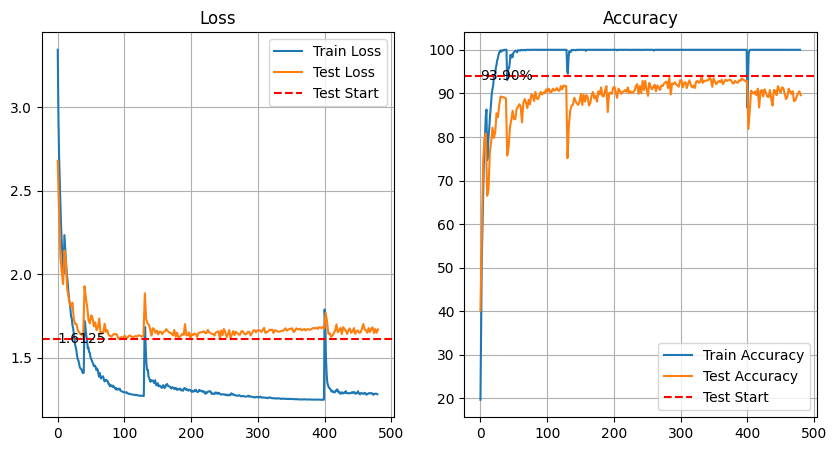

In [10]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc = [stat[1] for stat in train_stats]
test_loss = [stat[0] for stat in test_stats]
test_acc = [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(np.min(test_loss), color='r', linestyle='--', label='Test Start')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(np.max(test_acc), color='r', linestyle='--', label='Test Start')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [11]:
# !pip install seaborn

100%|██████████| 21/21 [00:00<00:00, 50.07it/s]


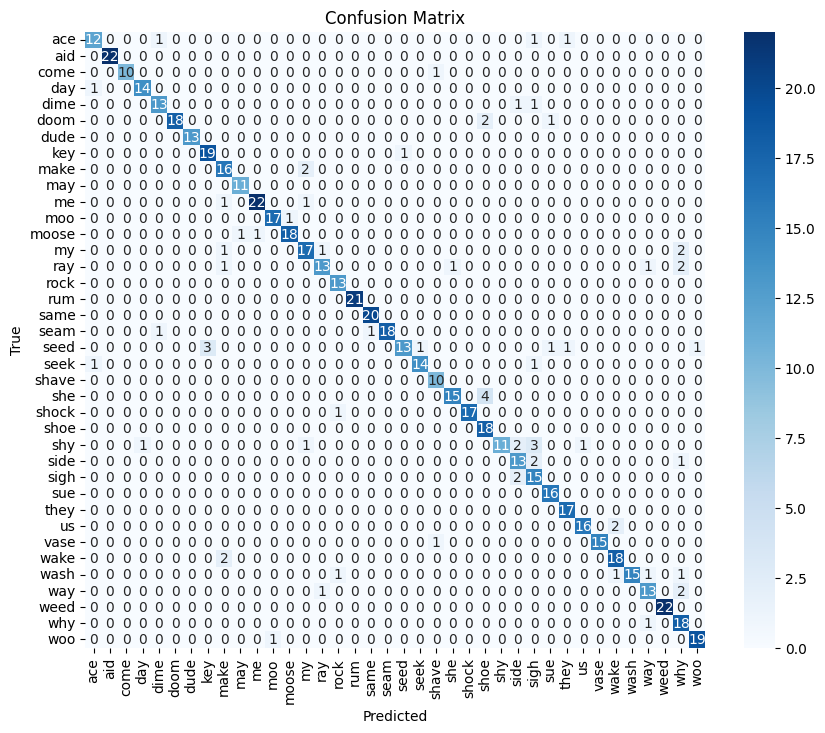

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to evaluate the model and generate the confusion matrix
def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ids, audio, adc1, adc2 in tqdm(dataloader):
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(adc)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ids.cpu().numpy())
    
    return all_labels, all_preds

# Evaluate the model on the validation set
labels, preds = evaluate_model(model, val_loader, device=global_device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Replace IDs with dataset names
label_names = [dataset.id_to_dataset(label) for label in range(output_length)]
pred_names = [dataset.id_to_dataset(pred) for pred in range(output_length)]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()